## Flight Dynamics Numerical Model and Analysis of Controllers with Root Locus

Assumptions made to derive linearized dynamic models with small-perturbations at steady, level flight conditions: (practical for waypoint line segment tracking applications)

1. Flat Earth: Earth is assumed to be perfectly flat and fixed, simplifying the conversion between Earth reference frame and aircraft body-fixed frame and enabling direct application of Newton's laws.

2. Non-rotating Earth: Coriolis and centripetal forces are neglected, allowing aircraft weight to be calculated simply as the product of mass and gravitational acceleration.

3. Constant Gravity Field: Gravitational acceleration is assumed to remain constant regardless of horizontal position or attitude, given the relatively small distance traveled and altitude changes.

4. Constant Aircraft Mass: Mass changes during flight are neglected due to the short time period of analysis, maintaining unchanged weight throughout the simulation.

5. Rigid Body Aircraft: Deformation of aircraft components due to aerodynamic loading is neglected, ensuring all aerodynamic coefficients remain constant.

6. Aircraft Symmetry: The aircraft is assumed symmetric about the xz-plane, considering only the product moment of inertia Ixz while Ixy and Iyz are zero.

7. Thrust in xz-plane: The thrust vector has no component in the y-direction, affecting only aerodynamic forces X, Z and moment M around the y-axis in the body frame.

8. Linearized Equations: Equations of motion are expressed as Taylor expansions up to first-order derivatives, valid only for small variations around the equilibrium point.

9. Zero Wind Velocity: The air is at rest relative to Earth's surface, making airflow speed equal to aircraft speed but in the opposite direction.

10. Neglected Rotating Mass Effects: Gyroscopic effects are disregarded, valid when pitch, roll, and yaw rates of the aircraft remain small during flight.

In [1]:
import data as cd #coefficient data of Cessna 172
import numpy as np

In [5]:
def rho_alt(hp):
    return cd.rho0 * np.power(((1 + (cd.lambda_air * hp / cd.Temp0))), (-((cd.g / (cd.lambda_air * cd.R)) + 1)))

In [6]:
def ss_symmetric(intial_cond): #Linearized Symmetric Motions Model
    #state: x = [û, α, θ, qc̄/V] (-, rad, rad, -)
    #control: u = [δe] rad. (elevator)
    V0 = intial_cond[0]
    hp0 = intial_cond[1]
    theta0 = intial_cond[2]
    mass = intial_cond[3]

    W = mass*cd.g
    rho = rho_alt(hp0)

    CZ0 = -W * np.cos(np.radians(theta0)) / (0.5 * rho * V0 ** 2 * cd.S)
    CX0 = W * np.sin(np.radians(theta0)) / (0.5 * rho * V0 ** 2 * cd.S)
    muc = mass / (rho * cd.S * cd.c)

    C1 = np.matrix([[-2 * muc, 0, 0, 0],
                    [0, cd.CZadot - 2 * muc, 0, 0],
                    [0, 0, -1, 0],
                    [0, cd.Cmadot, 0, -2 * muc * cd.KY2]]) * cd.c / V0

    C2 = np.matrix([[cd.CXu, cd.CXa, CZ0, 0],
                    [cd.CZu, cd.CZa, -CX0, cd.CZq + 2 * muc],
                    [0, 0, 0, 1],
                    [cd.Cmu, cd.Cma, 0, cd.Cmq]])

    C3 = np.matrix([[cd.CX_de],
                    [cd.CZ_de],
                    [0],
                    [cd.CM_de]])

    A = -C1.I * C2
    B = -C1.I * C3
    C = np.matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    D = np.matrix([[0],
                   [0],
                   [0],
                   [0]])
    
    return A, B, C, D


def ss_asymmetric(initial_cond): ##Linearized Asymmetric Motions Model
    # state: x = [β, φ, pb/2V, rb/2V] (rad,rad, roll rate (-), yaw rate (-))
    # controls = [δa, δr] (ailerons, rudder)
    V0 = initial_cond[0]
    hp0 = initial_cond[1]
    mass = initial_cond[3]
    # Calculate weight, density etc. at this moment
    W = mass * cd.g
    rho = rho_alt(hp0)
    mub = mass / (rho * cd.S * cd.b)
    CL = 2 * W / (rho * V0 ** 2 * cd.S) 

    C1 = np.matrix([[cd.CYbdot - 2 * mub, 0, 0, 0],
                    [0, -0.5, 0, 0],
                    [0, 0, -4 * mub * cd.KX2, 4 * mub * cd.KXZ],
                    [cd.Cnbdot, 0, 4 * mub * cd.KXZ, -4 * mub * cd.KZ2]]) * cd.b / V0

    C2 = np.matrix([[cd.CYb, CL, cd.CYp, cd.CYr - 4 * mub],
                    [0, 0, 1, 0],
                    [cd.Clb, 0, cd.Clp, cd.Clr],
                    [cd.Cnb, 0, cd.Cnp, cd.Cnr]])

    C3 = np.matrix([[-cd.CY_da, -cd.CY_dr],
                    [0, 0],
                    [-cd.Cl_da, -cd.Cl_dr],
                    [-cd.Cn_da, -cd.Cn_dr]])

    A = -C1.I * C2
    B = -C1.I * C3
    C = np.matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    D = np.matrix([[0, 0],
                   [0, 0],
                   [0, 0],
                   [0, 0]])
    
    return A, B, C, D


In [14]:
import control.matlab as ml

# model: choose between ss_asymmetric and ss_symmetric
def transfer_function(model):
    A, B, C, D = model
    sys = ml.ss(A, B, C, D)
    H = ml.tf(sys)
    return H

In [8]:
initial_cond = [65, 900, 2, 1000]  # 65 m/s (~126 knots), 1000m altitude, 2° pitch, 1100kg

H = transfer_function(ss_symmetric(initial_cond))
H_a = transfer_function(ss_asymmetric(initial_cond))
print(H)
print(H_a)

<TransferFunction>: sys[1]
Inputs (1): ['u[0]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']


Input 1 to output 1:
0.005898 s^3 + 0.05158 s^2 + 1.465 s + 11.48
---------------------------------------------
s^4 + 12.78 s^3 + 62.11 s^2 + 1.68 s + 0.5957

Input 1 to output 2:
  -0.2 s^3 - 31.89 s^2 - 0.7707 s - 0.2961
---------------------------------------------
s^4 + 12.78 s^3 + 62.11 s^2 + 1.68 s + 0.5957

Input 1 to output 3:
        -32.24 s^2 - 76.94 s - 2.453
---------------------------------------------
s^4 + 12.78 s^3 + 62.11 s^2 + 1.68 s + 0.5957

Input 1 to output 4:
-0.7408 s^3 - 1.768 s^2 - 0.05636 s + 1.326e-15
-----------------------------------------------
 s^4 + 12.78 s^3 + 62.11 s^2 + 1.68 s + 0.5957

<TransferFunction>: sys[3]
Inputs (2): ['u[0]', 'u[1]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']


Input 1 to output 1:
  0.02949 s^3 + 0.02103 s^2 - 0.1763 s - 0.003503
----------------------------------------------------
s^4 + 0.3996 s^3 + 0.1967 s^2 + 0.1003 s + 0

/tmp/ipykernel_1057593/328716150.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


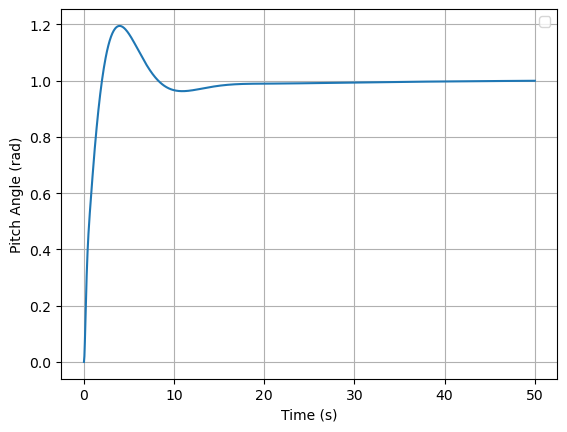

/home/mayank/miniconda3/envs/mlr/lib/python3.10/site-packages/control/config.py:363: FutureWarning: keyword 'kvect' is deprecated; use 'gains'
  warnings.warn(
/home/mayank/miniconda3/envs/mlr/lib/python3.10/site-packages/control/rlocus.py:210: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


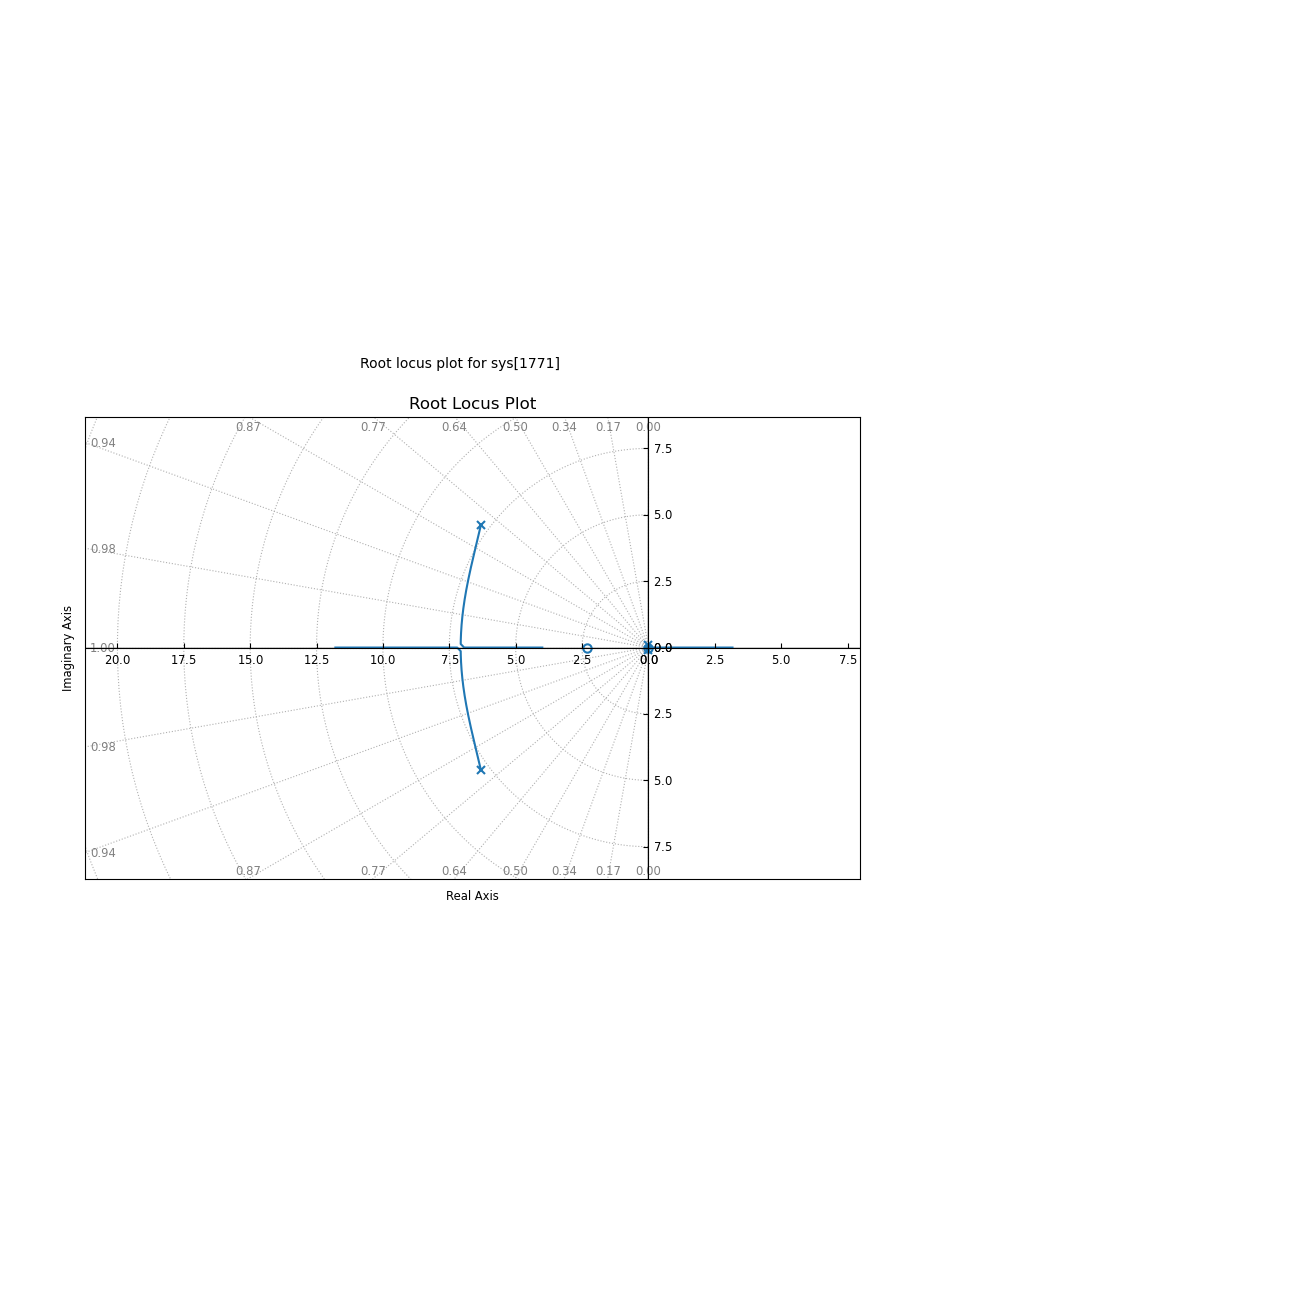

/home/mayank/miniconda3/envs/mlr/lib/python3.10/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


Gain Margin: inf dB
Phase Margin: 70.69769919829625 degrees
Gain Crossover Frequency: nan rad/s
Phase Crossover Frequency: 0.8989609540384866 rad/s


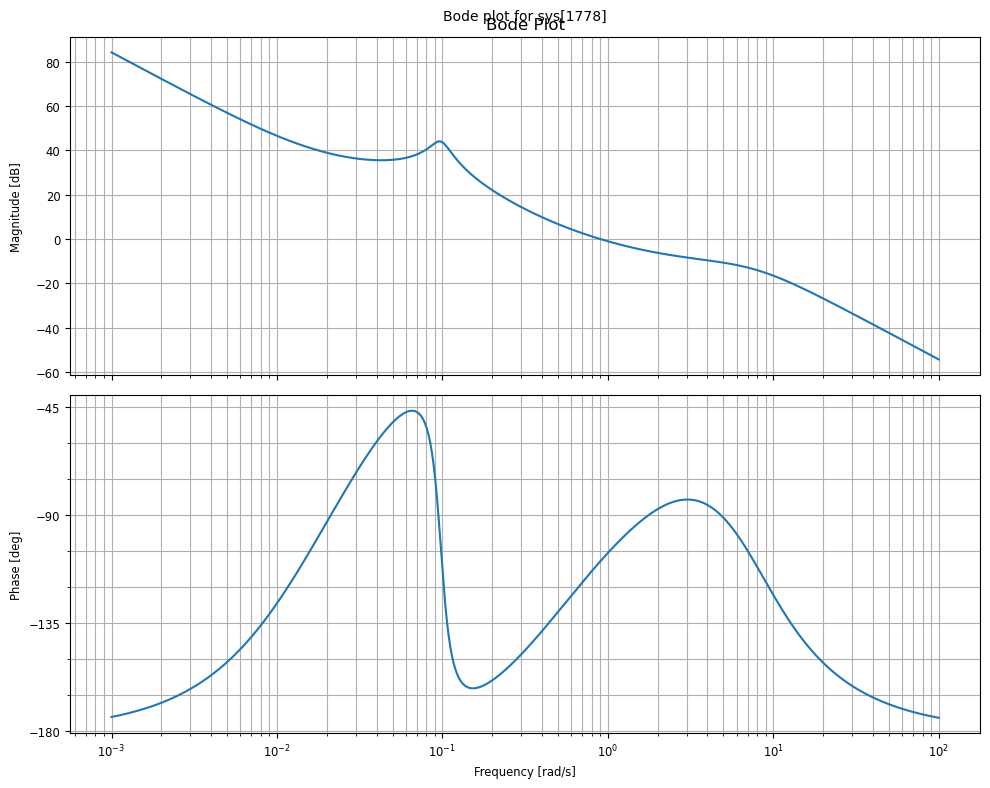

Open-loop poles: [-6.31254719+4.60301413j -6.31254719-4.60301413j -0.01245281+0.09704621j
 -0.01245281-0.09704621j]
Closed-loop poles: [-5.95840396+5.99446517j -5.95840396-5.99446517j -0.34440609+0.44146339j
 -0.34440609-0.44146339j -0.0303725 +0.j         -0.01400741+0.j        ]
Step Info: {'RiseTime': 1.4797463322093007, 'SettlingTime': 14.600163811131768, 'SettlingMin': 0.9175013381220847, 'SettlingMax': 1.1947782951170798, 'Overshoot': 19.477829511707977, 'Undershoot': 0, 'Peak': 1.1947782951170798, 'PeakTime': 3.945990219224802, 'SteadyStateValue': 1.0}
Step response values (first 10, last 10): [0.         0.02030715 0.06835799 0.12901492 0.19220729 0.25199174
 0.30548658 0.35187847 0.39160064 0.42571486] [0.99964407 0.99965386 0.99966364 0.99967339 0.99968312 0.99969283
 0.99970252 0.99971219 0.99972183 0.99973146]


In [154]:
import numpy as np
import control.matlab as ml
import matplotlib.pyplot as plt

# Plant transfer function (θ response)
num = [-31.93, -75.46, -2.382]
den = [1, 12.65, 61.36, 1.641, 0.5843]
G = ml.tf(num, den)


# PD controller # was challenging to tune!
# Kp = 0.05
# Kd = 0.01 
# C = ml.tf([Kd, Kp], [1])

K_theta = -0.3  # Pitch angle gain #simple gain with rate feedback 
K_q = -0.6      # Pitch rate gain
Ki = -0.004
C = ml.tf([K_q, K_theta, Ki], [1, 0, 0])
T = ml.feedback(C * G, 1)
t = np.linspace(0, 50, 1000)  # Zoom in early response
y = ml.step(T, t)[0]
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (rad)')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
root_locus = ml.rlocus(G, kvect=np.linspace(0, 2, 1000))
plt.grid(True)
plt.title('Root Locus Plot')
plt.xlabel('Real Axis')
plt.ylabel('Imaginary Axis')
plt.show()

plt.figure(figsize=(10, 8))
mag, phase, omega = ml.bode(G * C, dB=True)

# Calculate gain and phase margins
gm, pm, wgc, wpc = ml.margin(G * C)
print(f"Gain Margin: {20*np.log10(gm)} dB")
print(f"Phase Margin: {pm} degrees")
print(f"Gain Crossover Frequency: {wgc} rad/s")
print(f"Phase Crossover Frequency: {wpc} rad/s")

plt.subplot(211)
plt.grid(True)
plt.title('Bode Plot')
plt.subplot(212)
plt.grid(True)
plt.show()

print("Open-loop poles:", ml.pole(G))
print("Closed-loop poles:", ml.pole(T))
print("Step Info:", ml.stepinfo(T))
print("Step response values (first 10, last 10):", y[:10], y[-10:])

Open-loop poles: [ 0.02907242+0.46636316j  0.02907242-0.46636316j -0.44838314+0.j
 -0.0054617 +0.j        ]
Closed-loop poles: [ 0.1724507 +0.86119567j  0.1724507 -0.86119567j -0.53263784+0.j
 -0.10398178+0.34907845j -0.10398178-0.34907845j]
roll response (first 10, last 10) [ 0.         -0.00071249 -0.0028685  -0.00649404 -0.01161272 -0.01824559
 -0.02641113 -0.03612511 -0.04740056 -0.06024766] [1446.79182716 1614.76361919 1782.51133962 1949.70417732 2116.0066424
 2281.07913849 2444.57855313 2606.15886514 2765.47176835 2922.16731058]


/tmp/ipykernel_1057593/2468339213.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


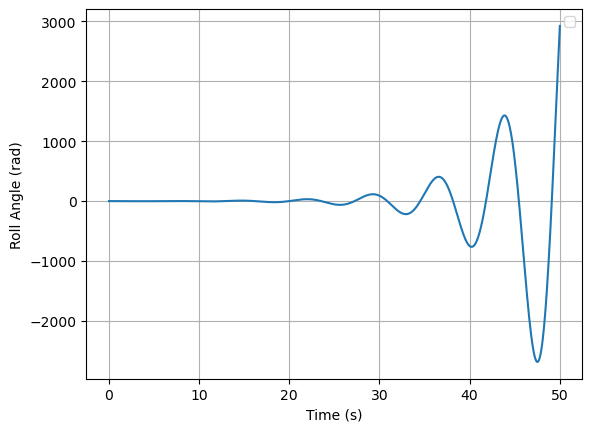

In [175]:
# Input 1 to output 2:
#             -1.13 s^2 - 0.2401 s - 0.1817
# -----------------------------------------------------
# s^4 + 0.3957 s^3 + 0.1944 s^2 + 0.09895 s + 0.0005347

def roll_controller():
    num = [-1.13, -0.2401, -0.1817]
    den = [1, 0.3957, 0.1944, 0.09895, 0.0005347]
    G_roll = ml.tf(num, den)

    K_phi = 0.3   # Roll angle gain (start with this value)
    K_p = 0.5     # Roll rate gain (start with this value)
    C_roll = ml.tf([K_p, K_phi], [1, 0])
    T_roll = ml.feedback(C_roll * G_roll, -1)
    print("Open-loop poles:", ml.pole(G_roll))
    print("Closed-loop poles:", ml.pole(T_roll))

    t = np.linspace(0, 50, 1000)  # Roll response is typically faster than pitch
    y = ml.step(T_roll, t)[0]
    print("roll response (first 10, last 10)", y[:10], y[-10:])
    plt.plot(t, y)
    plt.xlabel('Time (s)')
    plt.ylabel('Roll Angle (rad)')
    plt.grid()
    plt.legend()
    plt.show()


roll_controller()

System shape: (4, 4) (4, 2)
Open-loop eigenvalues: [ 0.0290761 +0.46636848j  0.0290761 -0.46636848j -0.44838178+0.j
 -0.00546185+0.j        ]
State feedback gain matrix K:
[[  1.16403159  -0.29292366 -32.84828215  -9.7033404 ]
 [-16.75909836  -3.80893817  29.2365777   98.53892964]]
Closed-loop poles: [-1. +1.j -1. -1.j -0.2+0.j -3. +0.j]
Step response values (first 10, last 10): [[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.00675192]
  [ 0.00077338]
  [ 0.00254235]
  [-0.00103307]]

 [[ 0.01369465]
  [ 0.00294203]
  [ 0.004715  ]
  [-0.00199992]]

 [[ 0.02075051]
  [ 0.00630186]
  [ 0.00656768]
  [-0.00289528]]

 [[ 0.02785142]
  [ 0.01067616]
  [ 0.00814337]
  [-0.00371559]]

 [[ 0.03493793]
  [ 0.01591197]
  [ 0.00947918]
  [-0.00445881]]

 [[ 0.04195839]
  [ 0.0218768 ]
  [ 0.01060723]
  [-0.00512409]]

 [[ 0.04886815]
  [ 0.02845589]
  [ 0.01155529]
  [-0.00571166]]

 [[ 0.05562888]
  [ 0.03554981]
  [ 0.01234741]
  [-0.00622256]]

 [[ 0.06220792]
  [ 0.04

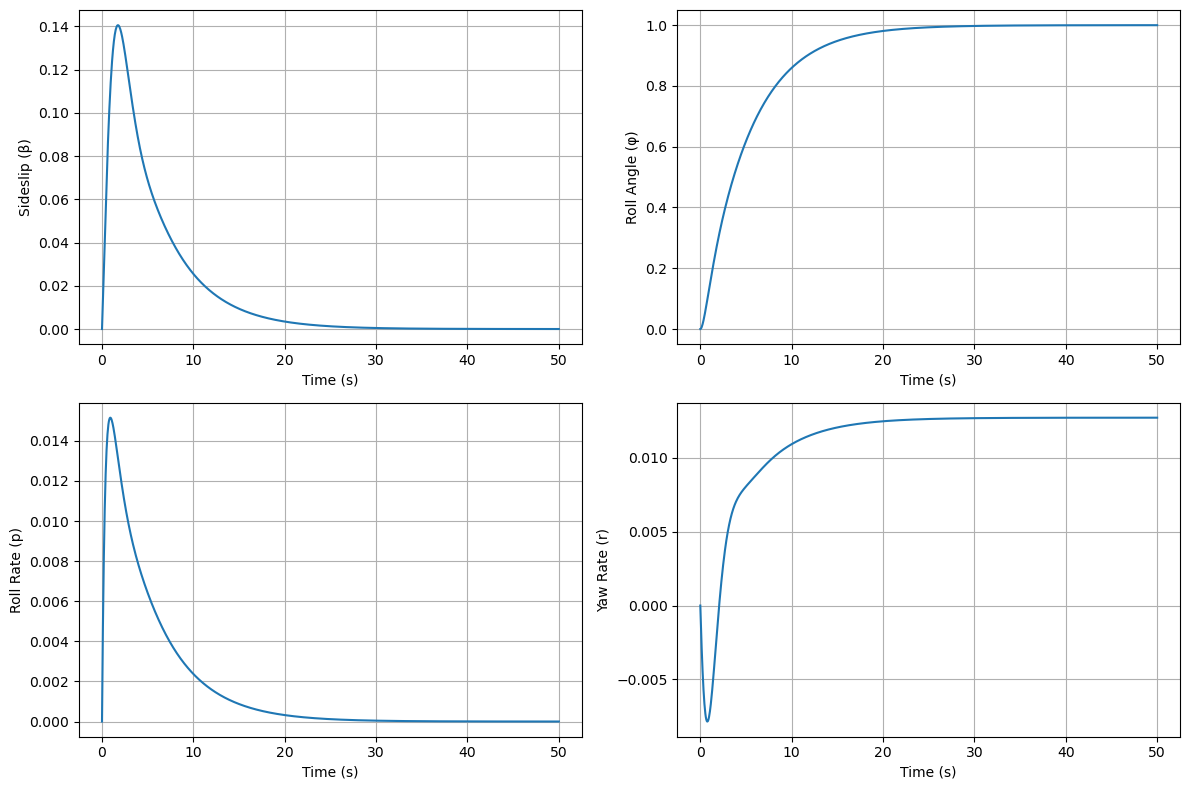

In [184]:
def design_state_feedback_controller(initial_cond):
    # Get the state-space matrices
    A, B, C, D = ss_asymmetric(initial_cond)
    
    # The state vector is: [β, φ, p, r]
    # The input vector is: [δa, δr]
    
    # Create the state-space system
    sys = ml.ss(A, B, C, D)
    
    # Print system information for verification
    print("System shape:", sys.A.shape, sys.B.shape)
    print("Open-loop eigenvalues:", np.linalg.eigvals(A))
    
    # Choose desired closed-loop poles
    # For lateral-directional dynamics, typical values might be:
    # - Dutch roll: complex pair with good damping
    # - Roll subsidence: fast real pole
    # - Spiral mode: stable real pole
    
    desired_poles = [-1.0+1.0j, -1.0-1.0j,  # Dutch roll (well damped)
                     -3.0,                   # Roll subsidence
                     -0.2]                   # Spiral mode
    
    # Calculate gain matrix K using pole placement
    # We need to ensure the system is controllable
    if np.linalg.matrix_rank(ml.ctrb(A, B)) < A.shape[0]:
        print("Warning: System is not controllable")
    
    # Compute gain matrix K
    K = ml.place(A, B, desired_poles)
    
    print("State feedback gain matrix K:")
    print(K)
    
    # Verify closed-loop poles
    A_cl = A - B @ K
    cl_poles = np.linalg.eigvals(A_cl)
    print("Closed-loop poles:", cl_poles)

    
    
    # Select which outputs to track (typically roll angle and sideslip)
    track_idx = [0, 1]  # Assuming β is index 0, φ is index 1
    C_track = C[track_idx, :]
    
    # Compute N matrix for reference tracking
    # If inverting C_track @ (-A_cl.I @ B) causes issues, an alternative method is needed
    try:
        N = -np.linalg.inv(C_track @ np.linalg.inv(A_cl) @ B)
    except:
        print("Warning: Could not compute reference gain matrix using direct inversion")
        # Alternative: use least squares or pseudoinverse
        N = np.eye(2)  # Placeholder for demonstration
    
    # For simulation, we'll use the full state-space model with reference input
    # x_dot = A_cl*x + B*N*r
    # y = C*x + D*N*r
    
    # For simulation, we'll create a state-space system with the closed-loop dynamics
    sys_cl = ml.ss(A_cl, B @ N, C, D @ N)
    
    # Set up simulation time
    t = np.linspace(0, 50, 1000)
    
    # We need to handle multiple input simulation differently
    # For a roll angle command with zero sideslip
    
    # First, get the step response for just the roll command (input index 1)
    y_roll, t = ml.step(sys_cl, T=t, input=1)

    print("Step response values (first 10, last 10):", y_roll[:10], y_roll[-10:])
    
    
    # Get the dimensions right
    if len(y_roll.shape) == 1:
        y_roll = y_roll.reshape(-1, 1)
    
    # Plot responses for all states
    plt.figure(figsize=(12, 8))
    
    labels = ['Sideslip (β)', 'Roll Angle (φ)', 'Roll Rate (p)', 'Yaw Rate (r)']
    for i in range(min(4, y_roll.shape[1])):
        plt.subplot(2, 2, i+1)
        plt.plot(t, y_roll[:, i])
        plt.xlabel('Time (s)')
        plt.ylabel(labels[i])
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return K

result = design_state_feedback_controller(initial_cond)



1. implement these controllers in flightgear and see if it works
2. Work on outer loop controllers
3. Waypoint Navigation
4. 

/home/mayank/miniconda3/envs/mlr/lib/python3.10/site-packages/control/rlocus.py:210: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(


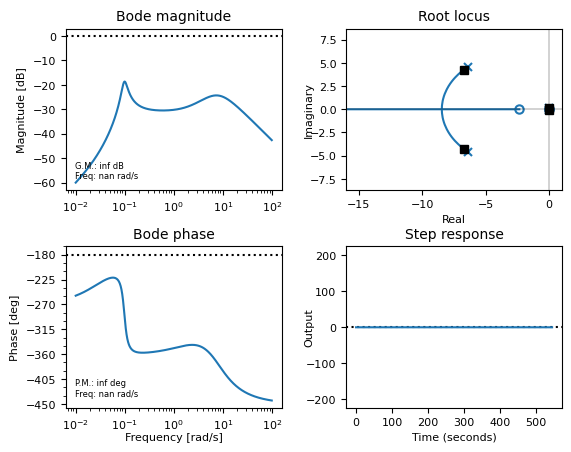

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


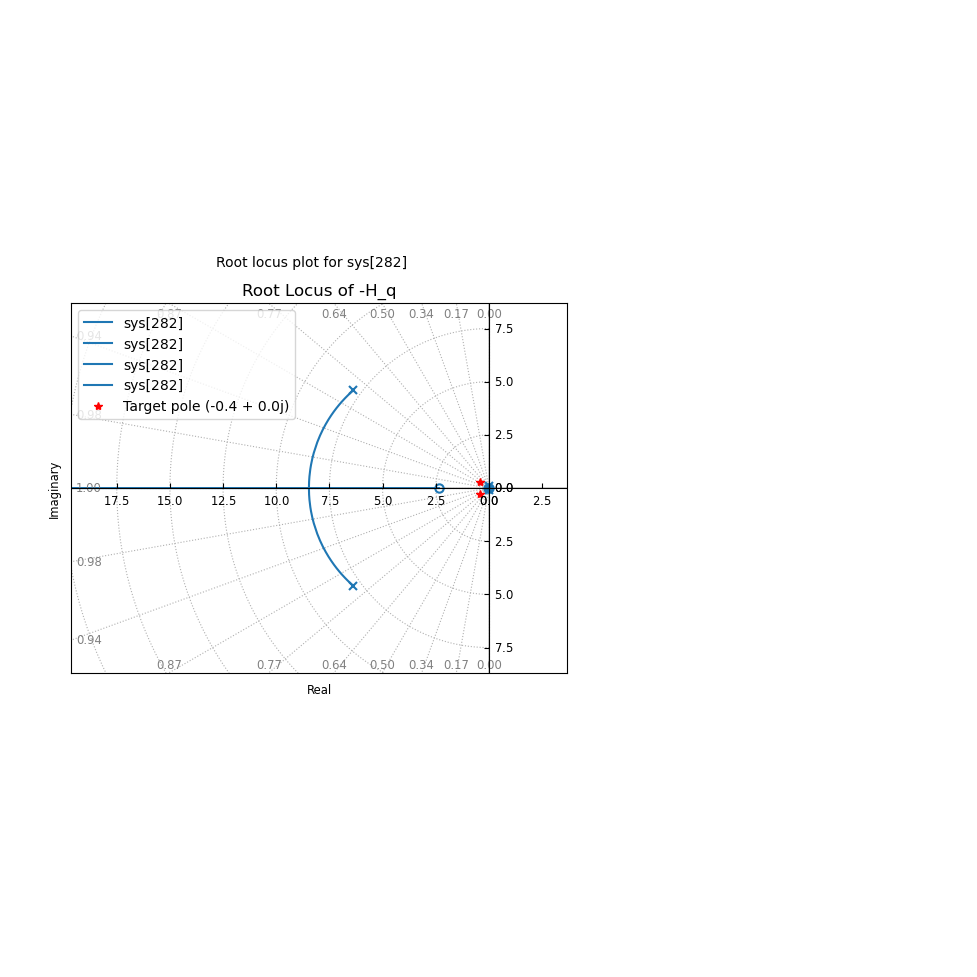

Roots shape: [[-6.37553578e+00-4.59732956j -6.37553578e+00+4.59732956j
  -1.26036069e-02-0.09738127j -1.26036069e-02+0.09738127j]
 [-6.50604498e+00-4.47997038j -6.50604498e+00+4.47997038j
  -1.26281164e-02-0.09688823j -1.26281164e-02+0.09688823j]
 [-6.63655445e+00-4.35554141j -6.63655445e+00+4.35554141j
  -1.26523488e-02-0.09640237j -1.26523488e-02+0.09640237j]
 ...
 [-9.58818447e+03+0.j         -2.35788179e+00+0.j
  -3.14556092e-02+0.j         -8.37678187e-04+0.j        ]
 [-9.57883733e+04+0.j         -2.35436241e+00+0.j
  -3.22341992e-02+0.j         -8.19465586e-05+0.j        ]
 [-9.57790227e+05+0.j         -2.35401017e+00+0.j
  -3.23102620e-02+0.j         -8.17738607e-06+0.j        ]]
Gains shape: [0.00000000e+00 3.52404875e-01 7.04809750e-01 ... 1.29287021e+04
 1.29287021e+05 1.29287021e+06]
Optimal K = 1292870.2103652132
Poles at K = 1292870.2103652132: [-9.57790227e+05+0.j -2.35401017e+00+0.j -3.23102620e-02+0.j
 -8.17738607e-06+0.j]


In [31]:
import matplotlib.pyplot as plt
import control.matlab as ml 
def sym_autopilot(model):
    A, B, C, D = model

    sys1 = ml.ss(A, B, C, D)

    H_q = ml.ss2tf(A, B, np.array([[0, 0, 0, 1]]), np.array([[0]]))
    
    ml.sisotool(-H_q)
    
    plt.figure()
    roots, gains = ml.rlocus(-H_q)  # Plot root locus
    plt.plot([-0.4], [0.3], 'r*', label='Target pole (-0.4 + 0.0j)')  # Example target
    plt.plot([-0.4], [-0.3], 'r*')  # Conjugate
    plt.grid(True)
    plt.legend()
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.title('Root Locus of -H_q')
    plt.show()

    print("Roots shape:", roots)
    print("Gains shape:", gains)

    target_pole = -0.4 + 0.1j
    distances = np.min(np.abs(roots - target_pole), axis=1)  # Min distance per gain
    idx = np.argmin(distances)  # Index of closest pole
    K_optimal = gains[idx]
    print(f"Optimal K = {K_optimal}")
    print(f"Poles at K = {K_optimal}: {roots[idx]}")

    Kr = 2.653827
    K_r = np.zeros((1, 4))
    K_r[0, 3] = Kr
    sys2 = ml.feedback(sys1, K_r, -1)
    
    # state_labels = ['Forward Velocity (u)', 'Angle of Attack (α)', 'Pitch Angle (θ)', 'Pitch Rate (q)']
    # t = np.linspace(0, 50, 1000)  # Roll response is typically faster than pitch
    # y = ml.step(sys2, t)[0]
    # # print("roll response (first 10, last 10)", y[:10], y[-10:])
    # for i in range(4):
    #     plt.subplot(2, 2, i+1)
    #     plt.plot(t, y[:,i])
    #     plt.grid(True)
    #     plt.title(f'Step Response: {state_labels[i]}')
    #     plt.xlabel('Time (s)')
    #     plt.ylabel('Amplitude')
    # plt.tight_layout()

    #Middle Loop (open loop)
    H_theta = ml.ss2tf(sys2.A, sys2.B, np.array([[0, 0, 1, 0]]), np.array([[0]]))
    
    # plt.figure(figsize=(10, 8))
    # roots, gains = ml.rlocus(-H_theta)
    # plt.axis('equal')  # Equal scaling helps with interpreting angles
    # plt.plot(-0.4, 0, 'rx', markersize=10, label='Target pole at -0.4')
    # plt.xlim([-7, 1]) 
    # plt.ylim([-7.5, 7.5])
    # plt.grid(True)

    target_pole = -0.4
    # distances = [min(abs(roots[:, j] - target_pole)) for j in range(roots.shape[1])]
    # idx = np.argmin(distances)  # Index of closest pole
    K_theta = -0.09622464212428093 # Corresponding gain
    K_theta_feedback = np.zeros((1, 4))
    K_theta_feedback[0, 2] = K_theta  # Feedback on θ (3rd state)
    sys3 = ml.feedback(sys2, K_theta_feedback, -1)

    # state_labels = ['Forward Velocity (u)', 'Angle of Attack (α)', 'Pitch Angle (θ)', 'Pitch Rate (q)']
    # t = np.linspace(0, 50, 1000)
    # y = ml.step(sys3, t)[0]
    # for i in range(4):
    #     plt.subplot(2, 2, i+1)
    #     plt.plot(t, y[:,i])
    #     plt.grid(True)
    #     plt.title(f'Step Response: {state_labels[i]}')
    #     plt.xlabel('Time (s)')
    #     plt.ylabel('Amplitude')
    # plt.tight_layout()

    # plt.show()

    C_gamma = np.array([[0, -1, 1, 0]]) 
    H_gamma = ml.ss2tf(sys3.A, sys3.B, C_gamma, np.array([[0]]))

    # kvect = np.linspace(0.0001, 7, 5000)  # Start slightly above zero
    # roots_h, gains_h = ml.rlocus(-H_gamma, kvect)

    # plt.axis('equal')
    # plt.xlim([-7, 1]) 
    # plt.ylim([-7.5, 7.5])
    # plt.grid(True)

    zeta = 0.7
    # x = np.linspace(-8, 0, 100)
    # y = np.tan(np.arccos(zeta)) * x
    # plt.plot(x, y, 'g--', label=f'Damping ratio = {zeta}')
    # plt.plot(x, -y, 'g--')
    
    # plt.title('Root Locus for Altitude Control Loop')
    # plt.xlabel('Real Axis')
    # plt.ylabel('Imaginary Axis')
    # plt.legend()

    # min_diff = float('inf')
    # best_idx = None

    # for i, root_array in enumerate(roots_h):
    #     for root in root_array:
    #         # Only consider complex poles (non-zero imaginary part)
    #         if abs(root.imag) > 0.1:
    #             damping = -root.real / np.sqrt(root.real**2 + root.imag**2)
    #             diff = abs(damping - zeta)
    #             if diff < min_diff:
    #                 min_diff = diff
    #                 best_idx = i
    
    # # If we found a suitable gain, return it
    # if best_idx is not None:
    #     Kh = gains_h[best_idx]
    #     print(f"Recommended Kh = {Kh}")

    Kh = -0.001
    sys_alt_control = ml.tf([Kh], [1])
    sys4 = ml.feedback(sys3* sys_alt_control, C_gamma, -1)
    # plt.figure(figsize=(10, 8))
    # state_labels = ['Forward Velocity (u)', 'Angle of Attack (α)', 'Pitch Angle (θ)', 'Pitch Rate (q)']
    # t = np.linspace(0, 50, 1000)
    # y = ml.step(sys4, t)[0]
    # for i in range(4):
    #     plt.subplot(2, 2, i+1)
    #     plt.plot(t, y[:,i])
    #     plt.grid(True)
    #     plt.title(f'Step Response: {state_labels[i]}')
    #     plt.xlabel('Time (s)')
    #     plt.ylabel('Amplitude')
    # plt.tight_layout()

    # plt.show()
    
    return sys1, H_q, sys2, sys3, sys4


sys1, H_q, sys2, sys3, sys4 = sym_autopilot(ss_symmetric(initial_cond))

# print(sys1)
# print(H_q)

In [213]:
def find_gain_for_damping(sys, target_damping=0.9):
    # Get a range of gains
    gains = np.linspace(0, 5, 2000)
    
    # For each gain, calculate closed-loop poles
    damping_ratios = []
    for K in gains:
        cl_sys = ml.feedback(-sys, K)
        poles = ml.pole(cl_sys)
        
        # Find the dominant complex poles
        complex_poles = [p for p in poles if abs(np.imag(p)) > 1e-6]
        if complex_poles:
            # Calculate damping for the least damped complex pair
            pole = complex_poles[0]
            damping = -np.real(pole) / np.sqrt(np.real(pole)**2 + np.imag(pole)**2)
            damping_ratios.append(damping)
        else:
            damping_ratios.append(1.0)  # All real poles
    
    # Find gain closest to target damping
    idx = np.argmin(np.abs(np.array(damping_ratios) - target_damping))
    return gains[idx], damping_ratios[idx]

K_r, actual_damping = find_gain_for_damping(H_q)
print(f"For damping ratio = 0.9, use K_r = {K_r:.6f}, resulting in actual damping = {actual_damping:.6f}")

For damping ratio = 0.9, use K_r = 2.653827, resulting in actual damping = 0.899961
